In [1]:
%matplotlib inline
%load_ext autoreload

import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
import utils
from matplotlib.colors import SymLogNorm
import xesmf as xe
from matplotlib import pyplot as plt, animation
from IPython.display import HTML, display

from scipy import signal


{'all_countries_step': array(1.65179026e+10),
 'all_countries_add': array(2.53307545e+08),
 'all_countries_pulse': array(16809173.13352966)}

In [2]:

import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

# Options

In [3]:
r = ['all_countries']
month = 'Jan' #options are Jan, Apr, Jul, Oct
time = '20160'
length_simulation = 60 #days
diagnostic = 'SpeciesConc'


## Import data

In [4]:
G_mean = xr.open_dataset('Outputs/g_mean_step_v_pulse.nc')['__xarray_dataarray_variable__']
ds_conc = xr.open_dataset('Outputs/ds_conc_step_v_pulse.nc')
ds_emis = xr.open_dataset('Outputs/ds_emis_step_v_pulse.nc')
G = xr.open_dataset('Outputs/g_step_v_pulse.nc')['__xarray_dataarray_variable__']
ds_conc_mean = xr.open_dataset('Outputs/ds_conc_mean_step_v_pulse.nc')
G_lev0 = xr.open_dataset('Outputs/g_lev0_mean_step_v_pulse.nc')['__xarray_dataarray_variable__'].isel(lev = 0)
ds_conc_lev0 = xr.open_dataset('Outputs/ds_conc_lev0_mean_step_v_pulse.nc')

Text(0, 0.5, "Green's Function")

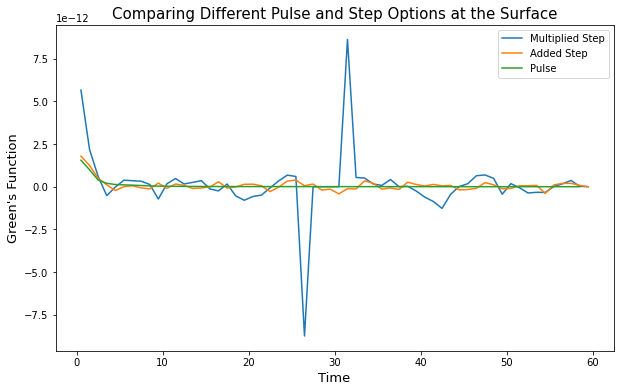

In [5]:
fig, ax = plt.subplots(figsize = [10,6])
G_lev0.sel(run = 'all_countries_step').plot(label = 'Multiplied Step')
G_lev0.sel(run = 'all_countries_add').plot(label = 'Added Step')
(G_lev0.sel(run = 'all_countries_pulse')).plot(label = 'Pulse')
plt.legend()
plt.title('Comparing Different Pulse and Step Options at the Surface', fontsize = 15)
plt.xlabel('Time', fontsize = 13)
plt.ylabel('Green\'s Function', fontsize = 13)

Text(0, 0.5, "Green's Function")

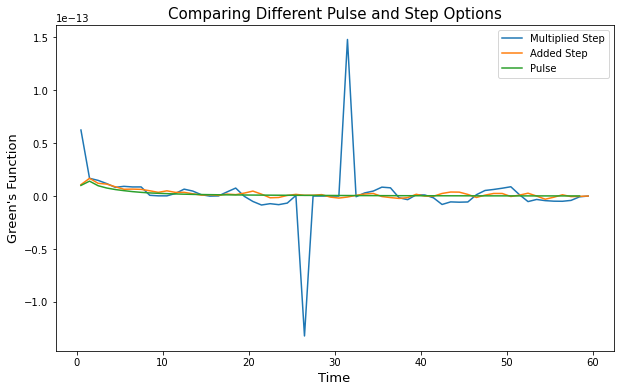

In [6]:
fig, ax = plt.subplots(figsize = [10,6])
G_mean.sel(run = 'all_countries_step').plot(label = 'Multiplied Step')
G_mean.sel(run = 'all_countries_add').plot(label = 'Added Step')
(G_mean.sel(run = 'all_countries_pulse')).plot(label = 'Pulse')
plt.legend()
plt.title('Comparing Different Pulse and Step Options', fontsize = 15)
plt.xlabel('Time', fontsize = 13)
plt.ylabel('Green\'s Function', fontsize = 13)

## Compare convolution to the actual 2x output

In [7]:
#emis = kg/day
#conc = μg m-3

In [8]:
emis_dif_2x = (ds_emis.sel(run = 'all_countries_add')-ds_emis.sel(run = 'base')).weighted(ds_emis['area'].sel(run = 'base').fillna(0)).sum(dim = ['lat','lon'])['EmisBC_Total']
utils.switch_conc_time(emis_dif_2x)

<xarray.DataArray 'EmisBC_Total' (time: 60)>
array([1.65179026e+10, 1.65179026e+10, 1.65179026e+10, 1.65179026e+10,
       1.65179026e+10, 1.65179026e+10, 1.65179026e+10, 1.65179026e+10,
       1.65179026e+10, 1.65179026e+10, 1.65179026e+10, 1.65179026e+10,
       1.65179026e+10, 1.65179026e+10, 1.65179026e+10, 1.65179026e+10,
       1.65179026e+10, 1.65179026e+10, 1.65179026e+10, 1.65179026e+10,
       1.65179026e+10, 1.65179026e+10, 1.65179026e+10, 1.65179026e+10,
       1.65179026e+10, 1.65179026e+10, 3.36187951e+07, 3.36187951e+07,
       3.36187951e+07, 3.36187951e+07, 3.36187951e+07, 1.71525128e+10,
       1.71525128e+10, 1.71525128e+10, 1.71525128e+10, 1.71525128e+10,
       1.71525128e+10, 1.71525128e+10, 1.71525128e+10, 1.71525128e+10,
       1.71525128e+10, 1.71525128e+10, 1.71525128e+10, 1.71525128e+10,
       1.71525128e+10, 1.71525128e+10, 1.71525128e+10, 1.71525128e+10,
       1.71525128e+10, 1.71525128e+10, 1.71525128e+10, 1.71525128e+10,
       1.71525128e+10, 1.71525128e+10, 1.71525128e+10, 1.71525128e+10,
       1.71525128e+10, 1.71525128e+10, 1.71525128e+10, 0.00000000e+00])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2016-02-29
    lev      float64 72.0
    run      <U4 'base'

In [ ]:
(ds_emis.sel(run = 'all_countries_step')-ds_emis.sel(run = 'base')).weighted(ds_emis['area'].fillna(0).sel(run = 'base')).mean(dim = ['lat','lon'])['EmisBC_Total']

In [36]:
conv_2x = {}
for run in G_lev0.run.values:
    conv_2x[run] = signal.convolve(np.array(G_lev0.sel(run = run)) , np.array(emis_dif_2x.values), mode = 'full')


In [46]:
f0_step = 1.65179026e+10 #(ds_emis.sel(run = 'all_countries_step')-ds_emis.sel(run = 'base')).weighted(ds_emis['area'].fillna(0).sel(run = 'base')).sum(dim = ['lat','lon'])['EmisBC_Total'].isel(time = 0)

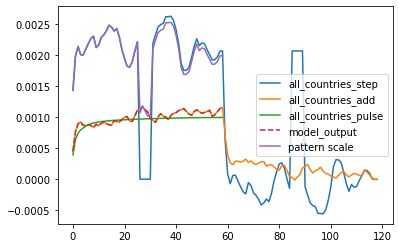

In [45]:
fig,ax = plt.subplots()
for r in conv_2x.keys():
    plt.plot(conv_2x[r], label = r)

plt.plot((ds_conc_lev0.sel(run = 'all_countries_add') - ds_conc_lev0.sel(run = 'base'))['BC_total'], linestyle = '--', label = 'model_output')
plt.plot(((ds_conc_lev0.sel(run = 'all_countries_step')-ds_conc_lev0.sel(run = 'base'))/f0_step)['BC_total']*emis_dif_2x, label = 'pattern scale')
plt.plot()
plt.legend()
#plt.xlim(0,55)

## Compare to complex pulse run

In [13]:
emis_dif_cos = (ds_emis.sel(run = 'all_countries_cos')-ds_emis.sel(run = 'base')).weighted(ds_emis['area'].sel(run = 'base').fillna(0)).sum(dim = ['lat','lon'])['EmisBC_Total']
utils.switch_conc_time(emis_dif_cos)

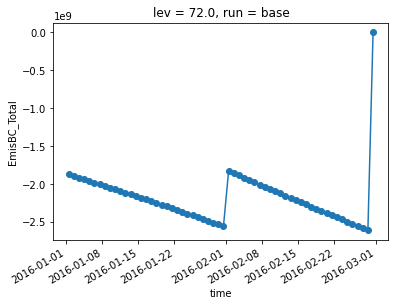

In [58]:
emis_dif_cos.plot(marker = 'o')

In [109]:
ds_test = xr.open_dataset('../GCrundirs/IRF_runs/mod_inputs/BC-em-anthro_CMIP_CEDS_2016' + '_' + 'cosin_all_countries.nc')

In [110]:
ds_base = xr.open_dataset('../GCrundirs/IRF_runs/mod_inputs/BC-em-anthro_CMIP_CEDS_2016.nc')

In [111]:
ds_test = ds_test-ds_base.resample(time="1D").interpolate("linear")

In [112]:
list(ds_test.data_vars)

['BC_agr',
 'BC_ene',
 'BC_ind',
 'BC_rco',
 'BC_shp',
 'BC_slv',
 'BC_tra',
 'BC_wst']

In [113]:
ds_test['all'] = xr.zeros_like(ds_test['BC_agr'])

In [114]:
for nm in list(ds_test.data_vars):
    ds_test['all'] += ds_test[nm]

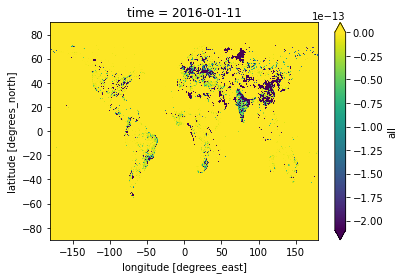

In [115]:
ds_test['all'].isel(time = 10).plot(robust = True)

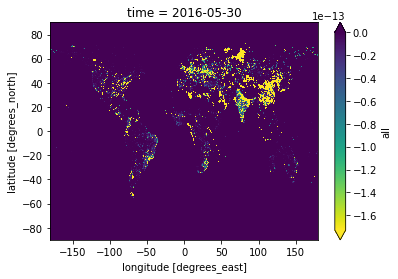

In [122]:
ds_test['all'].isel(time = 150).plot(robust = True, cmap = 'viridis_r')

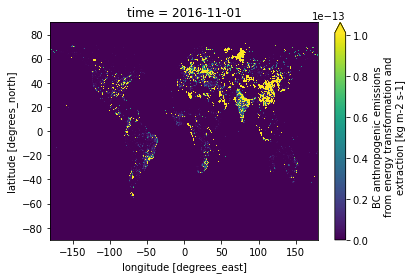

In [121]:
ds_base['BC_ene'].isel(time = 10).plot(robust = True)

In [ ]:
ds_test['all'].weighted(ds)

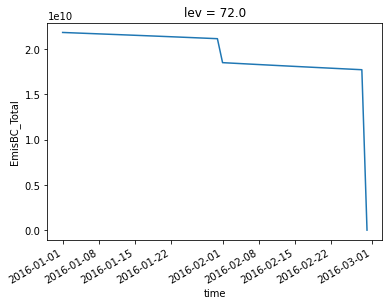

In [62]:
ds_emis.sel(run = 'all_countries_cos').weighted(ds_emis['area'].sel(run = 'base').fillna(0)).sum(dim = ['lat','lon'])['EmisBC_Total'].plot()

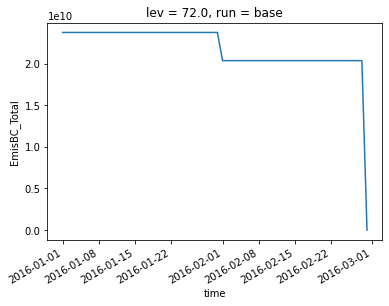

In [63]:
ds_emis.sel(run = 'base').weighted(ds_emis['area'].sel(run = 'base').fillna(0)).sum(dim = ['lat','lon'])['EmisBC_Total'].plot()

In [53]:
conv_cos = {}
for run in G_lev0.run.values:
    conv_cos[run] = signal.convolve(np.array(G_lev0.sel(run = run)) , np.array(emis_dif_cos.values), mode = 'full')


(0.0, 55.0)

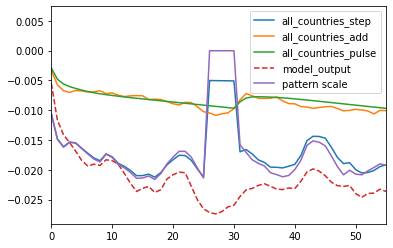

In [54]:
fig,ax = plt.subplots()
for r in conv_cos.keys():
    plt.plot(conv_cos[r], label = r)

plt.plot((ds_conc_lev0.sel(run = 'all_countries_cos') - ds_conc_lev0.sel(run = 'base'))['BC_total'], linestyle = '--', label = 'model_output')
plt.plot(((ds_conc_lev0.sel(run = 'all_countries_step')-ds_conc_lev0.sel(run = 'base'))/f0_step)['BC_total']*emis_dif_cos, label = 'pattern scale')
plt.plot()
plt.legend()
plt.xlim(0,55)

In [64]:
ds_conc_lev0

<xarray.Dataset>
Dimensions:   (time: 60, run: 5)
Coordinates:
  * time      (time) datetime64[ns] 2016-01-01T12:00:00 ... 2016-02-29T12:00:00
  * run       (run) object 'all_countries_step' 'all_countries_pulse' ... 'base'
    lev       float64 ...
Data variables:
    BC_total  (run, time) float64 ...